# Pruning a Dense-Network with MNIST

---

Please take a look at the `README` for sources and references.

## Imports and Data-Preparation

In [290]:
## Settings
model_type = "LeNet5"  ## Choice of "LeNet5" and "Dense"

In [291]:
## Tensorflow related
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Conv2D, Dense

## General
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Importing Pruned Model
import sys; 
if "..\\" not in sys.path: sys.path.append("..\\")
import src.masked_keras as msk
import src.wrappers as wrp

In [292]:
from importlib import reload
wrp = reload(wrp)
msk = reload(msk)

In [293]:
## Fetch Mnist-Dataset
(X_train, y_train), (X_test, y_test) = wrp.load_mnist() # 10000
num_classes = 10

In [294]:
if model_type == "LeNet5":
    X_train = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    X_test  = np.pad(X_test,  ((0,0),(2,2),(2,2),(0,0)), 'constant')

---

## Defining the Model, Loss, and Optimizer

In [295]:
## Defining the Model with Sequential API
if model_type == "Dense":
    def get_model():
        return keras.Sequential([
            layers.Flatten(input_shape=X_train.shape[1:]),
            layers.Dense(128, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(num_classes, activation="softmax")
        ])

if model_type == "LeNet5":
    def get_model():
        return keras.Sequential([
            layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', 
                input_shape=X_train.shape[1:]),
            layers.AveragePooling2D(),
            layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
            layers.AveragePooling2D(),
            layers.Flatten(),
            layers.Dense(units=120, activation='relu'),
            layers.Dense(units=84, activation='relu'),
            layers.Dense(units=10, activation = 'softmax')
        ])

## Extract init-model weights for training after pruning
model = get_model()
w_init = model.get_weights()

In [296]:
loss_fn = keras.losses.CategoricalCrossentropy()
metrics = [
    keras.metrics.TopKCategoricalAccuracy(
        k=1, name="categorical_accuracy", dtype=None), 
    keras.metrics.CategoricalCrossentropy()]

In [297]:
print(f"Accuracy at init: {wrp.simple_accuracy(model, X_test[:1000], y_test[:1000])}")

Accuracy at init: 0.10100000351667404


---

## ProsPr Pruning

Pruning logic from [Alizadeh, et al. (2022)](https://arxiv.org/pdf/2202.08132.pdf), but taking care of the pruning step-wise. Custom training loop modified from [Géron (2019)](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/). 
Combining it with the Jacobian times vector trick from [Wang, et al. (2020)](https://openreview.net/pdf?id=SkgsACVKPH). Therefore `Jvs` abbreviates "Jacobian-Vector-Products".

In [298]:
full_mask = [tf.ones_like(w) for w in model.trainable_weights]
masked_model = msk.TrackableMaskedModel(full_mask, model)
optimizer=keras.optimizers.SGD(learning_rate=0.1)
[np.allclose(w_, w_old) for w_, w_old in zip(masked_model.get_proper_weights(), w_init)]

Masking <keras.layers.convolutional.Conv2D object at 0x00000224B39B7BB0>
Masking <keras.layers.convolutional.Conv2D object at 0x00000224B72E9B20>
Masking <keras.layers.core.Dense object at 0x00000224B72E9CA0>
Masking <keras.layers.core.Dense object at 0x00000226B9279370>
Masking <keras.layers.core.Dense object at 0x00000224B39A50A0>


[True, True, True, True, True, True, True, True, True, True]

In [299]:
n_max = 100
with tf.GradientTape() as outer_tape:
    outer_tape.watch(masked_model.masks)
    for n in range(n_max):
        X_batch, y_batch = wrp.non_random_batch(X_train, y_train, n, 256)

        with tf.GradientTape(persistent=True) as inner_tape:
            y_pred = masked_model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + masked_model.losses)
        gradients = inner_tape.gradient(loss, masked_model.proper_weights)

        # for w, g in zip(masked_model.proper_weights, gradients):
        #     w.assign(w - 0.1 * g)
        optimizer.apply_gradients(zip(gradients, masked_model.proper_weights)) 

        print(loss.numpy(), end="\r")
     
meta_gradients = outer_tape.gradient(loss, masked_model.masks)
scores1 = wrp.compute_prospr_scores_from_meta_g(meta_gradients)

preds1 = np.argmax(masked_model.predict(X_test), axis=1)

In [300]:
masked_model.reset(get_model())
[np.allclose(w_new, w_) for w_new, w_ in zip(masked_model.get_proper_weights(), w_init)]

Masking <keras.layers.convolutional.Conv2D object at 0x00000224B13BA5E0>
Masking <keras.layers.convolutional.Conv2D object at 0x00000224B3B38E20>
Masking <keras.layers.core.Dense object at 0x0000022495FFA070>
Masking <keras.layers.core.Dense object at 0x0000022495FFA430>
Masking <keras.layers.core.Dense object at 0x0000022495FFA370>


[True, True, True, True, True, True, True, True, True, True]

In [301]:
n_max = 100

Jvs = [tf.Variable(var) for var in masked_model.proper_weights]

for n in range(n_max-1):

    X_batch, y_batch = wrp.non_random_batch(X_train, y_train, n, 256)
    w_updates = []
    
    with tf.GradientTape() as outer_tape: ## Pruning Step
        with tf.GradientTape() as inner_tape: # Update Step
            y_pred = masked_model(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + masked_model.losses)
        gradients = inner_tape.gradient(loss, masked_model.proper_weights)
        for w, g in zip(masked_model.proper_weights, gradients):
            w_updates.append(w - 0.1 * g)

        int_Jv = tf.reduce_sum([tf.reduce_sum(w_ * tf.stop_gradient(v_)) 
            for w_, v_ in zip(w_updates, Jvs)])
    Jvs = outer_tape.gradient(int_Jv, masked_model.proper_weights)
    for w, w_update in zip(masked_model.proper_weights, w_updates):
        w.assign(w_update) ## Update

    print(loss.numpy(), end="\r")


scores2 = wrp.compute_prospr_scores(Jvs, masked_model, 
    *wrp.non_random_batch(X_train, y_train, n, 256),
    loss_fn)

preds2 = np.argmax(masked_model.predict(X_test), axis=1)

In [302]:
masks1 = wrp.generate_pruning_mask(scores1, 0.5)
masks2 = wrp.generate_pruning_mask(scores2, 0.5)

In [303]:
np.mean(preds1 == preds2)

0.7558

In [304]:
# Jvs, prune_fit_history = wrp.prospr_loop(
#     model=model,
#     X_train=X_train, y_train=y_train,
#     loss_fn=loss_fn,
#     metrics=metrics,
#     prune_sg_lr=0.05,
#     validation_data=(X_test, y_test),
#     # optimizer=keras.optimizers.SGD(learning_rate=0.01),
# )

In [305]:
# X_M, y_M = wrp.random_batch(X_train, y_train, batch_size=128)
# prospr_scores = wrp.compute_prospr_scores(
#     Jvs=Jvs,
#     model=model,
#     X_train=X_M, y_train=y_M,
#     loss_fn=loss_fn)

In [306]:
# _ = wrp.visualize_prune_history(prune_fit_history)

---

## Train ProsPr-pruned Model

In [307]:
masks = masks1

In [308]:
keras.backend.clear_session()
model = get_model()
model.set_weights(w_init)

In [309]:
prospr_model = msk.StaticMaskedModel(masks, model)
print(f"Accuracy at init: {wrp.simple_accuracy(prospr_model, X_test, y_test)}")

Accuracy at init: 0.1388999968767166


In [310]:
len(prospr_model.trainable_weights)

10

In [311]:
prospr_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=loss_fn,
    metrics=["accuracy"]
)

In [312]:
pruned_fit = prospr_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1,
    batch_size=128
)

469/469 [==============================] - 3s 5ms/step - loss: 0.5333 - accuracy: 0.8513 - val_loss: 0.1849 - val_accuracy: 0.9462


In [313]:
with tf.GradientTape() as tape:
    y_pred = prospr_model(X_test)
    loss = loss_fn(y_test, y_pred)
gradients = tape.gradient(loss, model.trainable_weights)

In [314]:
## Confirm that the mask has not been trained
[np.all(mm == m) for mm, m in zip(prospr_model.masks, masks)]

[True, True, True, True, True, True, True, True, True, True]

In [315]:
## Sanity Checks
weights_flat = np.concatenate([w.flatten() for w in prospr_model.get_proper_weights()])
masks_flat   = np.concatenate([mask.numpy().flatten() for mask in masks])
grads_flat = np.concatenate([grad.numpy().flatten() for grad in gradients])

weights_zero = np.isclose(weights_flat, 0)
masks_zero = np.isclose(masks_flat, 0)
grads_zero = np.isclose(grads_flat, 0)

print(np.mean(weights_zero == masks_zero))
print(np.mean(grads_zero == masks_zero))

0.9999630514570043
0.7489592827056186


---

## GraSp Pruning

Pruning logic from [Wang, et al. (2020)](https://openreview.net/pdf?id=SkgsACVKPH).

In [316]:
## Testing Tape Behaviour
v = tf.Variable([1., 2., 3.])
with tf.GradientTape(persistent=True) as outer_tape:
    with tf.GradientTape() as tape:
       y = tf.reduce_sum(v ** 3.) + 2*tf.reduce_prod(v)
    dy  = tape.gradient(y, v)
    int_H = tf.reduce_sum(dy * tf.stop_gradient(dy))
d2y = outer_tape.jacobian(dy, v)
d2y_sum = outer_tape.gradient(dy, v)
Hg = outer_tape.gradient(int_H, v)

print(dy)
print(d2y)
print(d2y_sum)
print(tf.matmul([d2y], tf.transpose([dy])))
print(Hg)

tf.Tensor([15. 18. 31.], shape=(3,), dtype=float32)
tf.Tensor(
[[ 6.  6.  4.]
 [ 6. 12.  2.]
 [ 4.  2. 18.]], shape=(3, 3), dtype=float32)
tf.Tensor([16. 20. 24.], shape=(3,), dtype=float32)
tf.Tensor(
[[[322.]
  [368.]
  [654.]]], shape=(1, 3, 1), dtype=float32)
tf.Tensor([322. 368. 654.], shape=(3,), dtype=float32)


In [317]:
with tf.autodiff.ForwardAccumulator(
    v,
    dy) as acc:
    with tf.GradientTape() as tape:
        y = tf.reduce_sum(v ** 3.) + 2*tf.reduce_prod(v)
    backward = tape.gradient(y, v)
print(backward)  # gradient from backprop
acc.jvp(backward)  # forward-over-backward Hessian-vector product


tf.Tensor([15. 18. 31.], shape=(3,), dtype=float32)


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([322., 368., 654.], dtype=float32)>

In [319]:
## Reset Model
model = get_model()
model.set_weights(w_init)

## GraSp batch:
X_grasp, y_grasp = wrp.random_batch(X_train, y_train, batch_size=512)

In [320]:
## Method on Page 5
with tf.GradientTape(persistent=True) as outer_tape:
    with tf.GradientTape() as inner_tape:
        y_pred = model(X_grasp)
        loss = loss_fn(y_grasp, y_pred)
    gradients = inner_tape.gradient(loss, model.trainable_variables)
    int_Hg = tf.reduce_sum([tf.reduce_sum(g * tf.stop_gradient(g)) for g in gradients])
Hgs = outer_tape.gradient(int_Hg, model.trainable_variables)
grasp_scores = Hgs

In [321]:
## Plain Hessian-gradient-product
with tf.autodiff.ForwardAccumulator(
    model.trainable_variables,
    gradients) as acc:
    with tf.GradientTape() as tape:
        y_pred = model(X_grasp)
        loss = loss_fn(y_grasp, y_pred)
    backward = tape.gradient(loss, model.trainable_variables)
Hgs2 = acc.jvp(backward)

In [322]:
[np.allclose(Hg2, Hg1) for Hg2, Hg1 in zip(Hgs2, Hgs)]

[True, True, True, True, True, True, True, True, True, True]

---

## Train GraSp-pruned Model

In [323]:
masks = wrp.generate_pruning_mask(grasp_scores)

In [324]:
grasp_model = msk.StaticMaskedModel(masks, keras.models.clone_model(model))
grasp_model.set_weights(w_init)
print(f"Accuracy at init: {wrp.simple_accuracy(grasp_model, X_test, y_test)}")

Accuracy at init: 0.11079999804496765


In [325]:
grasp_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=loss_fn,
    metrics=["accuracy"]
)

In [326]:
pruned_fit = grasp_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1,
    batch_size=128
)

469/469 [==============================] - 3s 5ms/step - loss: 0.7689 - accuracy: 0.7758 - val_loss: 0.3557 - val_accuracy: 0.8923


## Sparsity vs. Accuracy

In [333]:
sparsity_range = np.linspace(0.9, 1., 20)

In [334]:
## ProsPr Pruning
prospr_scores = scores2
accuracy_prospr = []
loss_prospr = []

for sparsity in tqdm(sparsity_range):
    masks = wrp.generate_pruning_mask(
        prospr_scores, 
        sparsity=np.clip(sparsity, a_min=0., a_max=1.))
    prospr_model = msk.StaticMaskedModel(masks, keras.models.clone_model(model))
    prospr_model.set_weights(w_init)

    prospr_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    pruned_fit = prospr_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        verbose=0,
        epochs=1,
        batch_size=128
    )

    accuracy_prospr.append(pruned_fit.history['val_accuracy'])
    loss_prospr.append(pruned_fit.history['val_loss'])

100%|██████████| 20/20 [00:54<00:00,  2.72s/it]


In [335]:
## GraSp Pruning
accuracy_grasp = []
loss_grasp = []

for sparsity in tqdm(sparsity_range):
    masks = wrp.generate_pruning_mask(
        grasp_scores, 
        sparsity=np.clip(sparsity, a_min=0., a_max=1.))
    grasp_model = msk.StaticMaskedModel(masks, keras.models.clone_model(model))
    grasp_model.set_weights(w_init)

    grasp_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    pruned_fit = grasp_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        verbose=0,
        epochs=1,
        batch_size=128
    )

    accuracy_grasp.append(pruned_fit.history['val_accuracy'])
    loss_grasp.append(pruned_fit.history['val_loss'])

100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


In [336]:
## Random Pruning
weight_shapes = [var.shape for var in model.trainable_weights]
accuracy_random = []
loss_random = []

for sparsity in tqdm(sparsity_range):
    masks = wrp.generate_random_pruning_mask(
        weight_shapes, 
        sparsity=sparsity)
    pruned_model = msk.StaticMaskedModel(masks, keras.models.clone_model(model))
    pruned_model.set_weights(w_init)

    pruned_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    pruned_fit = pruned_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        verbose=0,
        epochs=1,
        batch_size=128
    )

    accuracy_random.append(pruned_fit.history['val_accuracy'])
    loss_random.append(pruned_fit.history['val_loss'])

100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


In [337]:
labels_acc  = ["rand. pruning acc.",  "ProsPr acc.", "GraSp acc."]
labels_loss = ["rand. pruning loss", "ProsPr loss", "GraSp loss"]
data_acc  = [accuracy_random, accuracy_prospr, accuracy_grasp]
data_loss = [    loss_random,     loss_prospr,     loss_grasp]
lines_acc  = ["k-",  "r-",  "g-"]
lines_loss = ["k--", "r--", "g--"]

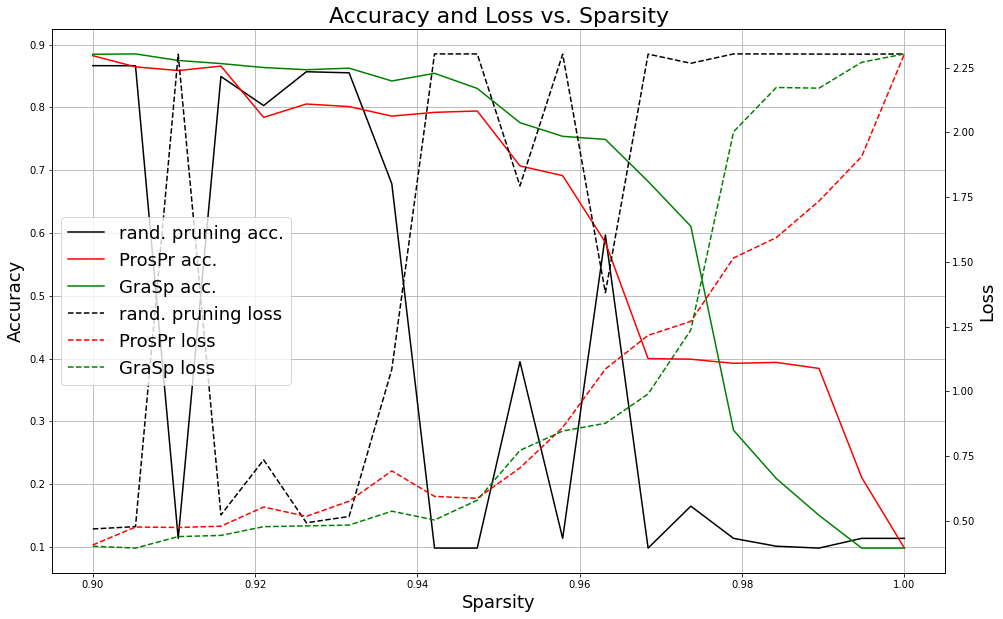

In [338]:
fig, ax0 = plt.subplots(figsize=(16, 10))
ax1 = ax0.twinx()
ax0.set_title("Accuracy and Loss vs. Sparsity", fontsize=22)

plt_acc  = [ax0.plot(sparsity_range, data, line, label=label) 
    for data, line, label in zip(data_acc, lines_acc, labels_acc)]
plt_loss = [ax1.plot(sparsity_range, data, line, label=label) 
    for data, line, label in zip(data_loss, lines_loss, labels_loss)]

ax1.set_ylabel("Loss", fontsize=18)
ax0.set_xlabel("Sparsity", fontsize=18)
ax0.set_ylabel("Accuracy", fontsize=18)
ax0.grid()
lns = [l[0] for l in plt_acc + plt_loss]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center left', fontsize=18)
plt.show()
plt.close()